In [1]:
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'font.size': 14,
})

np.set_printoptions(6, suppress=True)

from pylgmath import se3op, Transformation
from pysteam.evaluable import se3 as se3ev, vspace as vspaceev
from pysteam.evaluable.vspace import VSpaceStateVar
from pysteam.evaluable.p2p import P2PErrorEvaluator
from pysteam import problem, solver, trajectory

def add_plot_pose(ax, timestamp, T_mr, label=None):
    T_mr_vec = np.array([_.vec() for _ in T_mr]).squeeze()
    ax[0].plot(timestamp, T_mr_vec[:, 0], label=label)
    ax[1].plot(timestamp, T_mr_vec[:, 1], label=label)
    ax[2].plot(timestamp, T_mr_vec[:, 2], label=label)
    ax[3].plot(timestamp, T_mr_vec[:, 3+0], label=label)
    ax[4].plot(timestamp, T_mr_vec[:, 3+1], label=label)
    ax[5].plot(timestamp, T_mr_vec[:, 3+2], label=label)

def add_plot_velocity(ax, timestamp, w_mr_inr, label=None):
    w_mr_inr = np.array(w_mr_inr).squeeze()
    ax[0].plot(timestamp, w_mr_inr[:, 0], label=label)
    ax[1].plot(timestamp, w_mr_inr[:, 1], label=label)
    ax[2].plot(timestamp, w_mr_inr[:, 2], label=label)
    ax[3].plot(timestamp, w_mr_inr[:, 3+0], label=label)
    ax[4].plot(timestamp, w_mr_inr[:, 3+1], label=label)
    ax[5].plot(timestamp, w_mr_inr[:, 3+2], label=label)

def add_legend(ax, prefix = "velocity"):
    legend = ['x', 'y', 'z', 'roll', 'pitch', 'yaw']
    for i in range(6):
        ax[i].set_xlabel('time [s]')
        ax[i].set_ylabel(prefix + ' ' + legend[i])
        ax[i].legend()


filename = "/home/yuchen/ASRL/temp/doppler_odometry/boreas/aeva/07191552/steam_debug/association.txt"
asso = np.loadtxt(filename)
timestamps = asso[:, 0]
references = asso[:, 1:4][..., None]
queries = asso[:, 4:7][..., None]
information = asso[:, 7:].reshape((-1, 3, 3))

unique_timestamps, unique_indices = np.unique(timestamps, return_index=True)
unique_indices = list(unique_indices) + [len(timestamps)]

In [3]:
# ### convert p2p to pose measurements
# T_mr_meas_list = []
# T_mr_meas_cov_list = []
# for c in range(len(unique_indices) - 1):
#   print(f"processing knot {c}", end="\r")
#   begin_index = unique_indices[c]
#   end_index = unique_indices[c+1]

#   T_mr = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
#   T_mr_var = se3ev.SE3StateVar(T_mr)

#   # solve for pose of this time stamp
#   cost_terms = []
#   for i in range(begin_index, end_index):
#     ref_pt = references[i]
#     qry_pt = queries[i]
#     W = information[i]

#     error_func = P2PErrorEvaluator(T_mr_var, ref_pt, qry_pt)
#     loss_func = problem.L2LossFunc()
#     noise_model = problem.StaticNoiseModel(W, "information")
#     cost_terms.append(problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func))

#   ## Make optimization problem
#   opt_prob = problem.OptimizationProblem()
#   opt_prob.add_state_var(T_mr_var)
#   opt_prob.add_cost_term(*cost_terms)

#   ## Make solver and solve
#   optimizer = solver.GaussNewtonSolver(opt_prob)
#   optimizer.optimize()
#   covariance = solver.Covariance(opt_prob)

#   T_mr_meas_list.append(T_mr_var.value)
#   T_mr_meas_cov_list.append(covariance.query(T_mr_var))


### or generate some random pose measurements
T_mr_meas_list = []
T_mr_meas_cov_list = []

for i in range(len(unique_timestamps)):
  T_mr_meas_list.append(Transformation(T_ba=se3op.vec2tran(np.random.normal(0., 1.0, (6, 1)))))
  T_mr_meas_cov_list.append(np.eye(6) * 1e-1)


In [ ]:
### Save pose measurements to file
unique_timestamps_array = np.array(unique_timestamps)
T_mr_meas_array = np.array([x.vec().flatten() for x in T_mr_meas_list])
T_mr_meas_cov_array = np.array([ x.flatten() for x in T_mr_meas_cov_list])
np.savetxt("/home/yuchen/Desktop/timestamps.txt", unique_timestamps_array)
np.savetxt("/home/yuchen/Desktop/T_0k_measurements.txt", T_mr_meas_array)
np.savetxt("/home/yuchen/Desktop/T_0k_covariances.txt", T_mr_meas_cov_array)

Begin Optimization
------------------
Number of States:  198
Number of Cost Terms:  199
Initial Cost:  2952.08432696922
Iteration:    1  -  Cost:  2984.9613
Iteration:    2  -  Cost:  2517.2648
Iteration:    3  -  Cost:  2512.1456
Iteration:    4  -  Cost:  2511.2743
Iteration:    5  -  Cost:  2511.0741
Termination Cause:  CONVERGED RELATIVE CHANGE


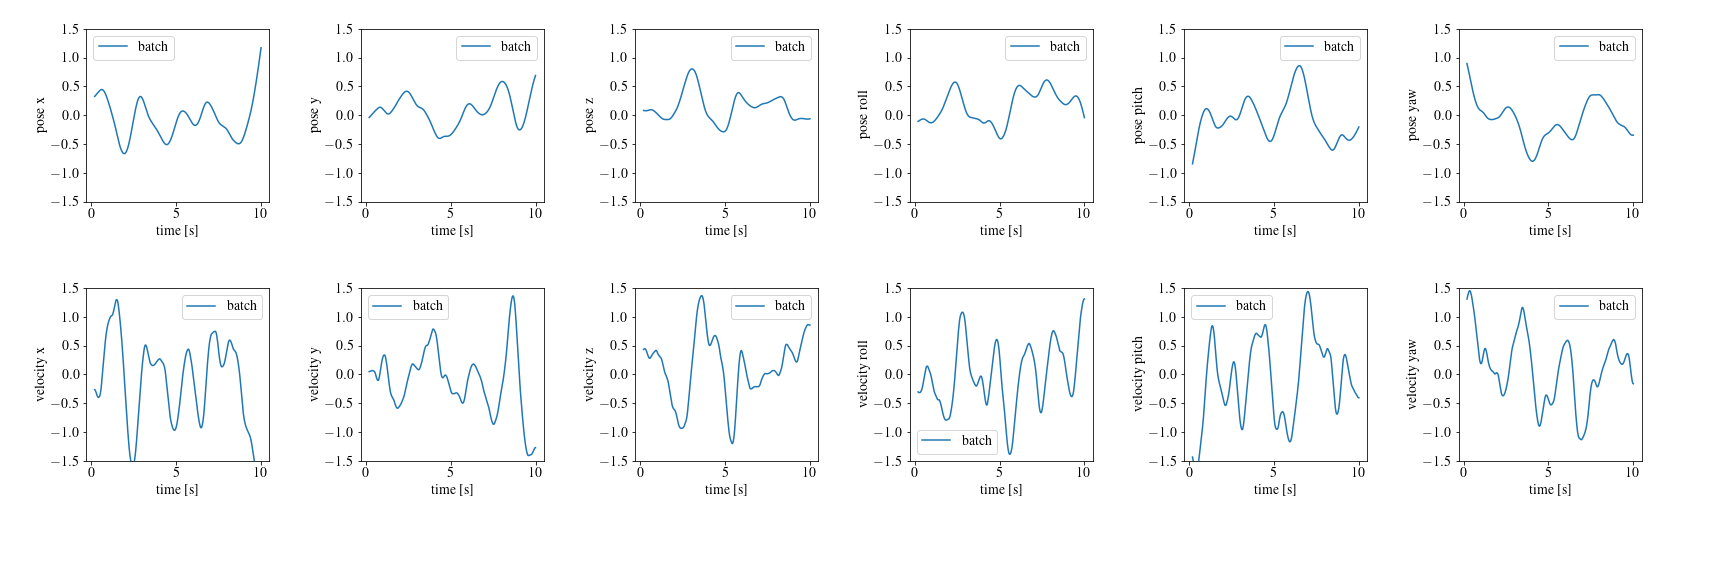

In [4]:
### Solve using batch optimization (with equivalent pose measurements)

## Setup trajectory
# qcd = np.array([1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1])
qcd = np.array([1e0, 1e0, 1e0, 1e0, 1e0, 1e0])
traj = trajectory.const_vel.Interface(qcd=qcd)

T_rm_vars = []
w_mr_inr_vars = []
for t in unique_timestamps:
  T_rm = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
  w_mr_inr = np.zeros((6, 1))
  time = trajectory.Time(secs=t)
  T_rm_vars.append(se3ev.SE3StateVar(T_rm))
  w_mr_inr_vars.append(vspaceev.VSpaceStateVar(w_mr_inr))
  traj.add_knot(time=time, T_k0=T_rm_vars[-1], w_0k_ink=w_mr_inr_vars[-1])

## prior on initial time
time_prior = trajectory.Time(secs=unique_timestamps[0])
T_rm_prior = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
w_mr_inr_prior = np.zeros((6, 1))
traj.add_pose_prior(time_prior, T_rm_prior, np.eye(6))
traj.add_velocity_prior(time_prior, w_mr_inr_prior, np.eye(6))

## Setup cost terms
cost_terms = []
for i in range(len(unique_timestamps)):
  time = trajectory.Time(secs=unique_timestamps[i])
  T_mr_meas = T_mr_meas_list[i]
  T_mr_meas_cov = T_mr_meas_cov_list[i]

  T_rm_eval = traj.get_pose_interpolator(time)
  error_func = se3ev.se3_error(se3ev.inv(T_rm_eval), T_mr_meas)
  loss_func = problem.L2LossFunc()
  noise_model = problem.StaticNoiseModel(T_mr_meas_cov, "covariance")
  cost_terms.append(problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func))

## Make optimization problem
opt_prob = problem.OptimizationProblem()
opt_prob.add_state_var(*T_rm_vars, *w_mr_inr_vars)
opt_prob.add_cost_term(*cost_terms, *traj.get_prior_cost_terms())

## Make solver and solve
optimizer = solver.GaussNewtonSolver(opt_prob, verbose=True)
optimizer.optimize()

## plot
timestamps_plot = np.arange(unique_timestamps[0], unique_timestamps[-1], 0.005)
T_mr_plot = []
w_mr_inr_plot = []
for i in timestamps_plot:
  time = trajectory.Time(secs=i)
  T_mr_plot.append(se3ev.inv(traj.get_pose_interpolator(time)).evaluate())
  w_mr_inr_plot.append(traj.get_velocity_interpolator(time).evaluate())

timestamps_plot_batch = timestamps_plot
T_mr_plot_batch = T_mr_plot
w_mr_inr_plot_batch = w_mr_inr_plot

fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.5, hspace=0.5)
add_plot_pose(ax[0], timestamps_plot_batch, T_mr_plot_batch, label="batch")
add_plot_velocity(ax[1], timestamps_plot_batch, w_mr_inr_plot_batch, label="batch")
add_legend(ax[0], 'pose')
add_legend(ax[1], 'velocity')

for j in range(2):
  for i in range(6):
      ax[j][i].set_ylim([-1.5, 1.5])

plt.show()

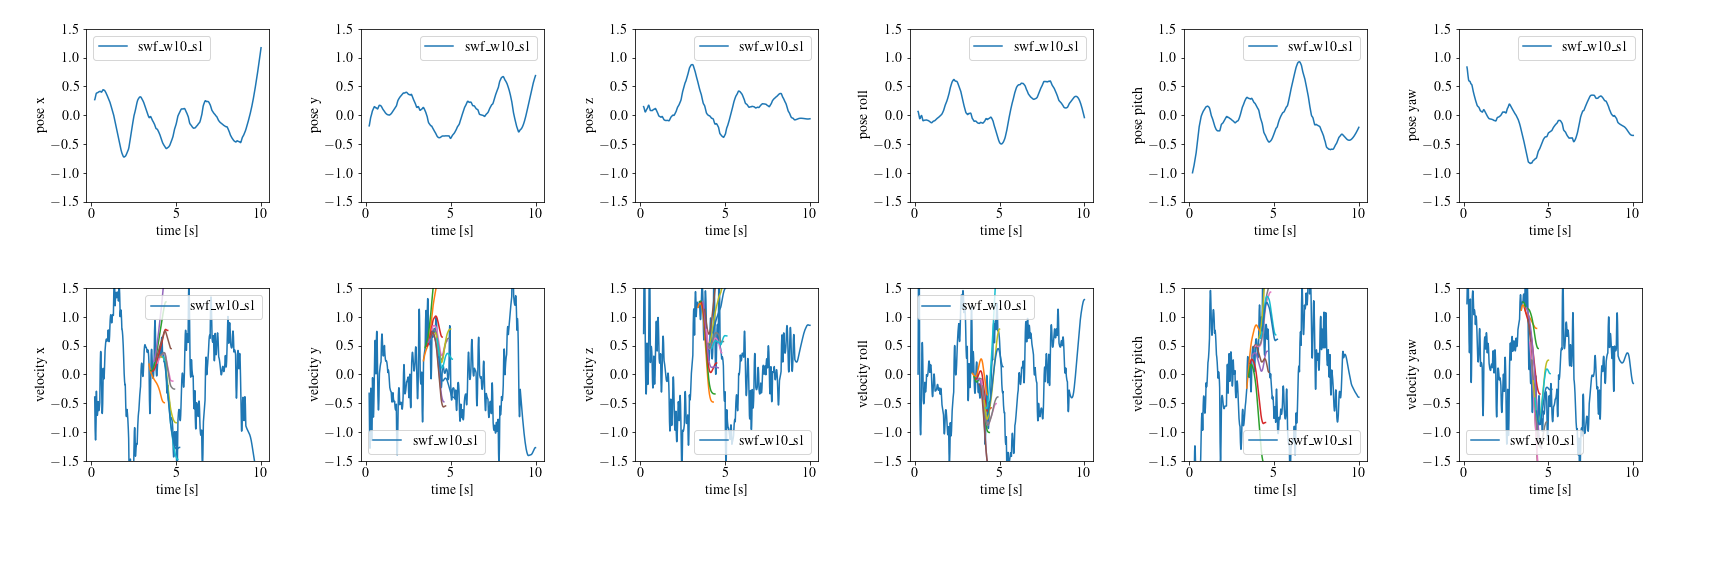

In [6]:
### Solve using sliding window optimization (with equivalent pose measurements)
WINDOW_SIZE = 10
STRIDE_SIZE = 1
# qcd = np.array([1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1])
qcd = np.array([1e0, 1e0, 1e0, 1e0, 1e0, 1e0])

T_rm_vars = []
w_mr_inr_vars = []
for t in unique_timestamps:
  T_rm = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
  w_mr_inr = np.zeros((6, 1))
  time = trajectory.Time(secs=t)
  T_rm_vars.append(se3ev.SE3StateVar(T_rm))
  w_mr_inr_vars.append(vspaceev.VSpaceStateVar(w_mr_inr))

#
sliding_window_filter = problem.SlidingWindowFilter()
curr_state_index = -1
marg_state_index = -1

#
curr_state_index += 1
sliding_window_filter.add_variable(T_rm_vars[curr_state_index], w_mr_inr_vars[curr_state_index])

# add cost term
error_func = se3ev.se3_error(se3ev.inv(T_rm_vars[curr_state_index]), T_mr_meas_list[curr_state_index])
loss_func = problem.L2LossFunc()
noise_model = problem.StaticNoiseModel(T_mr_meas_cov_list[curr_state_index], "covariance")
cost_term = problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
sliding_window_filter.add_cost_term(cost_term)

# intermediate state values
timestamp_interms = []
T_rm_interms = []
w_mr_inr_interms = []

while curr_state_index + 1 < len(unique_timestamps):
  print(f"curr_state_index: {curr_state_index}", end="\r")

  #
  added_state_index = curr_state_index

  #
  for i in range(STRIDE_SIZE):
    if curr_state_index + 1 >= len(unique_timestamps):
      break
    curr_state_index += 1
    sliding_window_filter.add_variable(T_rm_vars[curr_state_index], w_mr_inr_vars[curr_state_index])

  #
  traj = trajectory.const_vel.Interface(qcd=qcd)

  for i in range(added_state_index, curr_state_index+1):
    knot_time = trajectory.Time(secs=unique_timestamps[i])
    traj.add_knot(time=knot_time, T_k0=T_rm_vars[i], w_0k_ink=w_mr_inr_vars[i])

  # add prior
  if added_state_index == 0:
    time_prior = trajectory.Time(secs=unique_timestamps[0])
    T_rm_prior = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
    w_mr_inr_prior = np.zeros((6, 1))
    traj.add_pose_prior(time_prior, T_rm_prior, np.eye(6))
    traj.add_velocity_prior(time_prior, w_mr_inr_prior, np.eye(6))

  sliding_window_filter.add_cost_term(*traj.get_prior_cost_terms())

  # add cost term
  for i in range(added_state_index+1, curr_state_index+1):
    error_func = se3ev.se3_error(se3ev.inv(T_rm_vars[i]), T_mr_meas_list[i])
    loss_func = problem.L2LossFunc()
    noise_model = problem.StaticNoiseModel(T_mr_meas_cov_list[i], "covariance")
    cost_term = problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    sliding_window_filter.add_cost_term(cost_term)

  # marginalize variable
  marg_state_vars = []
  while curr_state_index - marg_state_index > WINDOW_SIZE:
    marg_state_index += 1
    marg_state_vars.append(T_rm_vars[marg_state_index])
    marg_state_vars.append(w_mr_inr_vars[marg_state_index])
  sliding_window_filter.marginalize_variable(*marg_state_vars)

  # Make solver and solve
  optimizer = solver.GaussNewtonSolver(sliding_window_filter, verbose=False)
  optimizer.optimize()

  # append
  timestamp_interm = []
  T_rm_interm = []
  w_mr_inr_interm = []
  for index in range(marg_state_index+1, curr_state_index+1):
    timestamp_interm.append(unique_timestamps[index])
    T_rm_interm.append(T_rm_vars[index].evaluate().matrix())
    w_mr_inr_interm.append(np.copy(w_mr_inr_vars[index].evaluate()))
  timestamp_interms.append(timestamp_interm)
  T_rm_interms.append(T_rm_interm)
  w_mr_inr_interms.append(w_mr_inr_interm)

## Setup trajectory for plotting
traj = trajectory.const_vel.Interface(qcd=qcd)
for i in range(len(unique_timestamps)):
  knot_time = trajectory.Time(secs=unique_timestamps[i])
  traj.add_knot(time=knot_time, T_k0=T_rm_vars[i], w_0k_ink=w_mr_inr_vars[i])

## plot
timestamps_plot = np.arange(unique_timestamps[0], unique_timestamps[-1], 0.005)
T_mr_plot = []
w_mr_inr_plot = []
for i in timestamps_plot:
  time = trajectory.Time(secs=i)
  T_mr_plot.append(se3ev.inv(traj.get_pose_interpolator(time)).evaluate())
  w_mr_inr_plot.append(traj.get_velocity_interpolator(time).evaluate())

timestamps_plot_swf = timestamps_plot
T_mr_plot_swf = T_mr_plot
w_mr_inr_plot_swf = w_mr_inr_plot

fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.5, hspace=0.5)
add_plot_pose(ax[0], timestamps_plot_swf, T_mr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")
add_plot_velocity(ax[1], timestamps_plot_swf, w_mr_inr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")
add_legend(ax[0], 'pose')
add_legend(ax[1], 'velocity')

for i in range(40, 50):
  traj = trajectory.const_vel.Interface(qcd=qcd)
  for j in range(len(timestamp_interms[i])):
    knot_time = trajectory.Time(secs=timestamp_interms[i][j])
    T_rm = se3ev.SE3StateVar(Transformation(T_ba=T_rm_interms[i][j]))
    w_mr_inr = vspaceev.VSpaceStateVar(w_mr_inr_interms[i][j])
    traj.add_knot(time=knot_time, T_k0=T_rm, w_0k_ink=w_mr_inr)
  #
  timestamp_interm_plot = np.arange(timestamp_interms[i][0], timestamp_interms[i][-1], 0.005)
  T_mr_interm_plot = [se3ev.inv(traj.get_pose_interpolator(trajectory.Time(time))).evaluate() for time in timestamp_interm_plot]
  w_mr_inr_interm_plot = [traj.get_velocity_interpolator(trajectory.Time(time)).evaluate() for time in timestamp_interm_plot]
  add_plot_velocity(ax[1], timestamp_interm_plot, w_mr_inr_interm_plot)

for j in range(2):
  for i in range(6):
      ax[j][i].set_ylim([-1.5, 1.5])

plt.show()

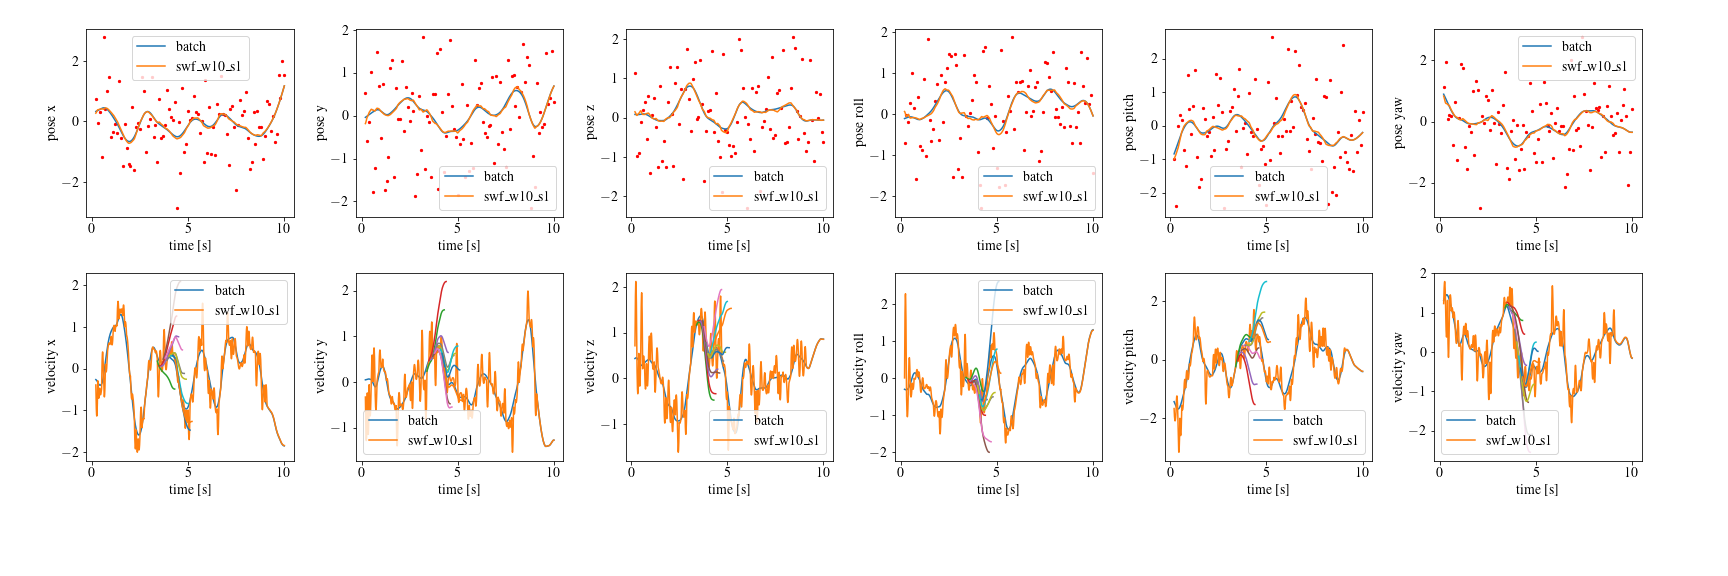

In [7]:
def add_plot_pose_meas(ax, timestamp, T_mr, label=None, size=None, color=None):
    T_mr_vec = np.array([_.vec() for _ in T_mr]).squeeze()
    ax[0].scatter(timestamp, T_mr_vec[:, 0], label=label, s=size, color=color)
    ax[1].scatter(timestamp, T_mr_vec[:, 1], label=label, s=size, color=color)
    ax[2].scatter(timestamp, T_mr_vec[:, 2], label=label, s=size, color=color)
    ax[3].scatter(timestamp, T_mr_vec[:, 3+0], label=label, s=size, color=color)
    ax[4].scatter(timestamp, T_mr_vec[:, 3+1], label=label, s=size, color=color)
    ax[5].scatter(timestamp, T_mr_vec[:, 3+2], label=label, s=size, color=color)


fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.3, hspace=0.3)

add_plot_pose(ax[0], timestamps_plot_batch, T_mr_plot_batch, label="batch")
add_plot_velocity(ax[1], timestamps_plot_batch, w_mr_inr_plot_batch, label="batch")

add_plot_pose(ax[0], timestamps_plot_swf, T_mr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")
add_plot_velocity(ax[1], timestamps_plot_swf, w_mr_inr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")

add_plot_pose_meas(ax[0], unique_timestamps, T_mr_meas_list, label=None, size=5, color='red')

for i in range(40, 50):
  traj = trajectory.const_vel.Interface(qcd=qcd)
  for j in range(len(timestamp_interms[i])):
    knot_time = trajectory.Time(secs=timestamp_interms[i][j])
    T_rm = se3ev.SE3StateVar(Transformation(T_ba=T_rm_interms[i][j]))
    w_mr_inr = vspaceev.VSpaceStateVar(w_mr_inr_interms[i][j])
    traj.add_knot(time=knot_time, T_k0=T_rm, w_0k_ink=w_mr_inr)
  #
  timestamp_interm_plot = np.arange(timestamp_interms[i][0], timestamp_interms[i][-1], 0.005)
  T_mr_interm_plot = [se3ev.inv(traj.get_pose_interpolator(trajectory.Time(time))).evaluate() for time in timestamp_interm_plot]
  w_mr_inr_interm_plot = [traj.get_velocity_interpolator(trajectory.Time(time)).evaluate() for time in timestamp_interm_plot]
  add_plot_velocity(ax[1], timestamp_interm_plot, w_mr_inr_interm_plot)

add_legend(ax[0], 'pose')
add_legend(ax[1], 'velocity')
plt.show()


In [ ]:
### CONST ACC Prior - Solve using batch optimization (with equivalent pose measurements)

## Setup trajectory
qcd = np.array([1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1])
traj = trajectory.const_acc.Interface(qcd=qcd)

T_rm_vars = []
w_mr_inr_vars = []
dw_mr_inr_vars = []
for t in unique_timestamps:
  T_rm = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
  w_mr_inr = np.zeros((6, 1))
  dw_mr_inr = np.zeros((6, 1))
  time = trajectory.Time(secs=t)
  T_rm_vars.append(se3ev.SE3StateVar(T_rm))
  w_mr_inr_vars.append(vspaceev.VSpaceStateVar(w_mr_inr))
  dw_mr_inr_vars.append(vspaceev.VSpaceStateVar(dw_mr_inr))
  traj.add_knot(time=time, T_k0=T_rm_vars[-1], w_0k_ink=w_mr_inr_vars[-1], dw_0k_ink=dw_mr_inr_vars[-1])

## prior on initial time
time_prior = trajectory.Time(secs=unique_timestamps[0])
T_rm_prior = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
w_mr_inr_prior = np.zeros((6, 1))
dw_mr_inr_prior = np.zeros((6, 1))
traj.add_pose_prior(time_prior, T_rm_prior, np.eye(6))
traj.add_velocity_prior(time_prior, w_mr_inr_prior, np.eye(6))
traj.add_acceleration_prior(time_prior, dw_mr_inr_prior, np.eye(6))

## Setup cost terms
cost_terms = []
for i in range(len(unique_timestamps)):
  time = trajectory.Time(secs=unique_timestamps[i])
  T_mr_meas = T_mr_meas_list[i]
  T_mr_meas_cov = T_mr_meas_cov_list[i]

  T_rm_eval = traj.get_pose_interpolator(time)
  error_func = se3ev.se3_error(se3ev.inv(T_rm_eval), T_mr_meas)
  loss_func = problem.L2LossFunc()
  noise_model = problem.StaticNoiseModel(T_mr_meas_cov, "covariance")
  cost_terms.append(problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func))

## Make optimization problem
opt_prob = problem.OptimizationProblem()
opt_prob.add_state_var(*T_rm_vars, *w_mr_inr_vars, *dw_mr_inr_vars)
opt_prob.add_cost_term(*cost_terms, *traj.get_prior_cost_terms())

## Make solver and solve
optimizer = solver.GaussNewtonSolver(opt_prob, verbose=True)
optimizer.optimize()

## plot
timestamps_plot = np.arange(unique_timestamps[0], unique_timestamps[-1], 0.005)
T_mr_plot = []
w_mr_inr_plot = []
for i in timestamps_plot:
  time = trajectory.Time(secs=i)
  T_mr_plot.append(se3ev.inv(traj.get_pose_interpolator(time)).evaluate())
  w_mr_inr_plot.append(traj.get_velocity_interpolator(time).evaluate())

timestamps_plot_batch = timestamps_plot
T_mr_plot_batch = T_mr_plot
w_mr_inr_plot_batch = w_mr_inr_plot

fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.3, hspace=0.3)
add_plot_pose(ax[0], timestamps_plot_batch, T_mr_plot_batch, label="batch")
add_plot_velocity(ax[1], timestamps_plot_batch, w_mr_inr_plot_batch, label="batch")
add_legend(ax[0], 'pose')
add_legend(ax[1], 'velocity')
plt.show()

In [ ]:
### CONST ACC Prior - Solve using sliding window optimization (with equivalent pose measurements)
WINDOW_SIZE = 10
STRIDE_SIZE = 1
qcd = np.array([1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1])

T_rm_vars = []
w_mr_inr_vars = []
dw_mr_inr_vars = []
for t in unique_timestamps:
  T_rm = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
  w_mr_inr = np.zeros((6, 1))
  dw_mr_inr = np.zeros((6, 1))
  time = trajectory.Time(secs=t)
  T_rm_vars.append(se3ev.SE3StateVar(T_rm))
  w_mr_inr_vars.append(vspaceev.VSpaceStateVar(w_mr_inr))
  dw_mr_inr_vars.append(vspaceev.VSpaceStateVar(dw_mr_inr))

#
sliding_window_filter = filter.SlidingWindowFilter()
curr_state_index = -1
marg_state_index = -1

#
curr_state_index += 1
sliding_window_filter.add_variable(T_rm_vars[curr_state_index], w_mr_inr_vars[curr_state_index], dw_mr_inr_vars[curr_state_index])

# add cost term
error_func = se3ev.se3_error(se3ev.inv(T_rm_vars[curr_state_index]), T_mr_meas_list[curr_state_index])
loss_func = problem.L2LossFunc()
noise_model = problem.StaticNoiseModel(T_mr_meas_cov_list[curr_state_index], "covariance")
cost_term = problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
sliding_window_filter.add_cost_term(cost_term)

while curr_state_index + 1 < len(unique_timestamps):
  print(f"curr_state_index: {curr_state_index}", end="\r")

  #
  added_state_index = curr_state_index

  #
  for i in range(STRIDE_SIZE):
    if curr_state_index + 1 >= len(unique_timestamps):
      break
    curr_state_index += 1
    sliding_window_filter.add_variable(T_rm_vars[curr_state_index], w_mr_inr_vars[curr_state_index], dw_mr_inr_vars[curr_state_index])

  #
  traj = trajectory.const_acc.Interface(qcd=qcd)

  for i in range(added_state_index, curr_state_index+1):
    knot_time = trajectory.Time(secs=unique_timestamps[i])
    traj.add_knot(time=knot_time, T_k0=T_rm_vars[i], w_0k_ink=w_mr_inr_vars[i], dw_0k_ink=dw_mr_inr_vars[i])

  # add prior
  if added_state_index == 0:
    time_prior = trajectory.Time(secs=unique_timestamps[0])
    T_rm_prior = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
    w_mr_inr_prior = np.zeros((6, 1))
    dw_mr_inr_prior = np.zeros((6, 1))
    traj.add_pose_prior(time_prior, T_rm_prior, np.eye(6))
    traj.add_velocity_prior(time_prior, w_mr_inr_prior, np.eye(6))
    traj.add_acceleration_prior(time_prior, dw_mr_inr_prior, np.eye(6))

  sliding_window_filter.add_cost_term(*traj.get_prior_cost_terms())

  # add cost term
  for i in range(added_state_index+1, curr_state_index+1):
    error_func = se3ev.se3_error(se3ev.inv(T_rm_vars[i]), T_mr_meas_list[i])
    loss_func = problem.L2LossFunc()
    noise_model = problem.StaticNoiseModel(T_mr_meas_cov_list[i], "covariance")
    cost_term = problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    sliding_window_filter.add_cost_term(cost_term)

  # marginalize variable
  marg_state_vars = []
  while curr_state_index - marg_state_index > WINDOW_SIZE:
    marg_state_index += 1
    marg_state_vars.append(T_rm_vars[marg_state_index])
    marg_state_vars.append(w_mr_inr_vars[marg_state_index])
    marg_state_vars.append(dw_mr_inr_vars[marg_state_index])
  sliding_window_filter.marginalize_variable(*marg_state_vars)

  # Make solver and solve
  optimizer = solver.GaussNewtonSolver(sliding_window_filter, verbose=False)
  optimizer.optimize()

## Setup trajectory for plotting
traj = trajectory.const_acc.Interface(qcd=qcd)
for i in range(len(unique_timestamps)):
  knot_time = trajectory.Time(secs=unique_timestamps[i])
  traj.add_knot(time=knot_time, T_k0=T_rm_vars[i], w_0k_ink=w_mr_inr_vars[i], dw_0k_ink=dw_mr_inr_vars[i])

## plot
timestamps_plot = np.arange(unique_timestamps[0], unique_timestamps[-1], 0.005)
T_mr_plot = []
w_mr_inr_plot = []
for i in timestamps_plot:
  time = trajectory.Time(secs=i)
  T_mr_plot.append(se3ev.inv(traj.get_pose_interpolator(time)).evaluate())
  w_mr_inr_plot.append(traj.get_velocity_interpolator(time).evaluate())

timestamps_plot_swf = timestamps_plot
T_mr_plot_swf = T_mr_plot
w_mr_inr_plot_swf = w_mr_inr_plot

fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.3, hspace=0.3)
add_plot_pose(ax[0], timestamps_plot_swf, T_mr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")
add_plot_velocity(ax[1], timestamps_plot_swf, w_mr_inr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")
add_legend(ax[0], 'pose')
add_legend(ax[1], 'velocity')
plt.show()

In [ ]:
### Solve using batch optimization (with raw points measurements)

## Setup trajectory
Qc_inv = np.diag([10., 10., 10., 100., 100., 100.0])
traj = trajectory.const_vel.Interface(Qc_inv=Qc_inv)

T_rm_vars = []
w_mr_inr_vars = []
for t in unique_timestamps:
  T_rm = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
  w_mr_inr = np.zeros((6, 1))
  time = trajectory.Time(secs=t)
  T_rm_vars.append(se3ev.SE3StateVar(T_rm))
  w_mr_inr_vars.append(vspaceev.VSpaceStateVar(w_mr_inr))
  traj.add_knot(time=time, T_k0=T_rm_vars[-1], w_0k_ink=w_mr_inr_vars[-1])


## Setup cost terms
cost_terms = []
for i in range(timestamps.shape[0]):
  time = trajectory.Time(secs=timestamps[i])
  ref_pt = references[i]
  qry_pt = queries[i]
  W = information[i]

  T_rm_eval = traj.get_pose_interpolator(time)
  error_func = P2PErrorEvaluator(se3ev.inv(T_rm_eval), ref_pt, qry_pt)
  loss_func = problem.L2LossFunc()
  noise_model = problem.StaticNoiseModel(W, "information")
  cost_terms.append(problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func))

## Make optimization problem
opt_prob = problem.OptimizationProblem()
opt_prob.add_state_var(*T_rm_vars, *w_mr_inr_vars)
opt_prob.add_cost_term(*cost_terms, *traj.get_prior_cost_terms())

## Make solver and solve
optimizer = solver.GaussNewtonSolver(opt_prob, verbose=True)
optimizer.optimize()

## plot
T_mr = [se3ev.inv(T_rm).evaluate() for T_rm in T_rm_vars]
w_mr_inr = [w_mr_inr.evaluate() for w_mr_inr in w_mr_inr_vars]

fig, ax = plt.subplots(3, 2, figsize=(16, 12))
add_plot_velocity(ax, unique_timestamps, w_mr_inr, label="batch")
add_legend(ax)
plt.show()

In [2]:
### Generate some velocity measurements
ACCELERATION = -0.01

w_mr_inr_meas_list = []
w_mr_inr_meas_cov_list = []
initial_time = unique_timestamps[0]
for i in range(len(unique_timestamps)):
  time = unique_timestamps[i]
  dt = time - initial_time

  w_mr_inr_meas_list.append(np.ones((6, 1)) * ACCELERATION * dt)
  w_mr_inr_meas_cov_list.append(np.eye(6) * 1e-1)

Begin Optimization
------------------
Number of States:  198
Number of Cost Terms:  199
Initial Cost:  9.556626589602232
Iteration:    1  -  Cost:     0.2372
Iteration:    2  -  Cost:     0.2372
Termination Cause:  CONVERGED ABSOLUTE CHANGE


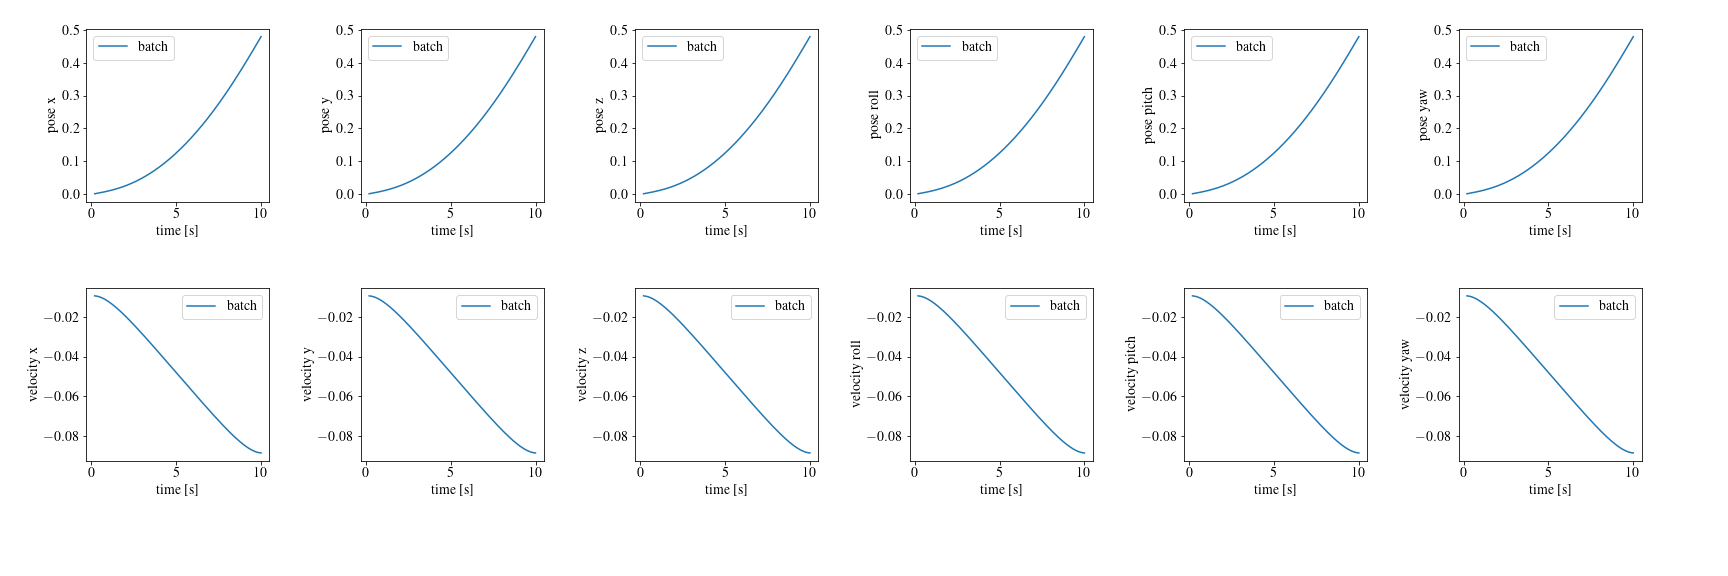

In [3]:
### CONST VEL Prior - Solve using batch optimization (with equivalent velocity measurements)

## Setup trajectory
# qcd = np.array([1., 1., 1., 1., 1., 1.])
qcd = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
traj = trajectory.const_vel.Interface(qcd=qcd)

T_rm_vars = []
w_mr_inr_vars = []
for t in unique_timestamps:
  T_rm = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
  w_mr_inr = np.zeros((6, 1))
  time = trajectory.Time(secs=t)
  T_rm_vars.append(se3ev.SE3StateVar(T_rm))
  w_mr_inr_vars.append(vspaceev.VSpaceStateVar(w_mr_inr))
  traj.add_knot(time=time, T_k0=T_rm_vars[-1], w_0k_ink=w_mr_inr_vars[-1])

## prior on initial time
time_prior = trajectory.Time(secs=unique_timestamps[0])
T_rm_prior = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
w_mr_inr_prior = np.zeros((6, 1))
traj.add_pose_prior(time_prior, T_rm_prior, np.eye(6))
traj.add_velocity_prior(time_prior, w_mr_inr_prior, np.eye(6))

## Setup cost terms
cost_terms = []
for i in range(len(unique_timestamps)):
  time = trajectory.Time(secs=unique_timestamps[i])
  w_mr_inr_meas = w_mr_inr_meas_list[i]
  w_mr_inr_meas_cov = w_mr_inr_meas_cov_list[i]

  w_mr_inr_eval = traj.get_velocity_interpolator(time)
  error_func = vspaceev.vspace_error(w_mr_inr_eval, w_mr_inr_meas)
  loss_func = problem.L2LossFunc()
  noise_model = problem.StaticNoiseModel(w_mr_inr_meas_cov, "covariance")
  cost_terms.append(problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func))

## Make optimization problem
opt_prob = problem.OptimizationProblem()
opt_prob.add_state_var(*T_rm_vars, *w_mr_inr_vars)
opt_prob.add_cost_term(*cost_terms, *traj.get_prior_cost_terms())

## Make solver and solve
optimizer = solver.GaussNewtonSolver(opt_prob, verbose=True)
optimizer.optimize()

## plot
timestamps_plot = np.arange(unique_timestamps[0], unique_timestamps[-1], 0.005)
T_mr_plot = []
w_mr_inr_plot = []
for i in timestamps_plot:
  time = trajectory.Time(secs=i)
  T_mr_plot.append(se3ev.inv(traj.get_pose_interpolator(time)).evaluate())
  w_mr_inr_plot.append(traj.get_velocity_interpolator(time).evaluate())

timestamps_plot_batch = timestamps_plot
T_mr_plot_batch = T_mr_plot
w_mr_inr_plot_batch = w_mr_inr_plot

fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.5, hspace=0.5)
add_plot_pose(ax[0], timestamps_plot_batch, T_mr_plot_batch, label="batch")
add_plot_velocity(ax[1], timestamps_plot_batch, w_mr_inr_plot_batch, label="batch")
add_legend(ax[0], 'pose')
add_legend(ax[1], 'velocity')
plt.show()

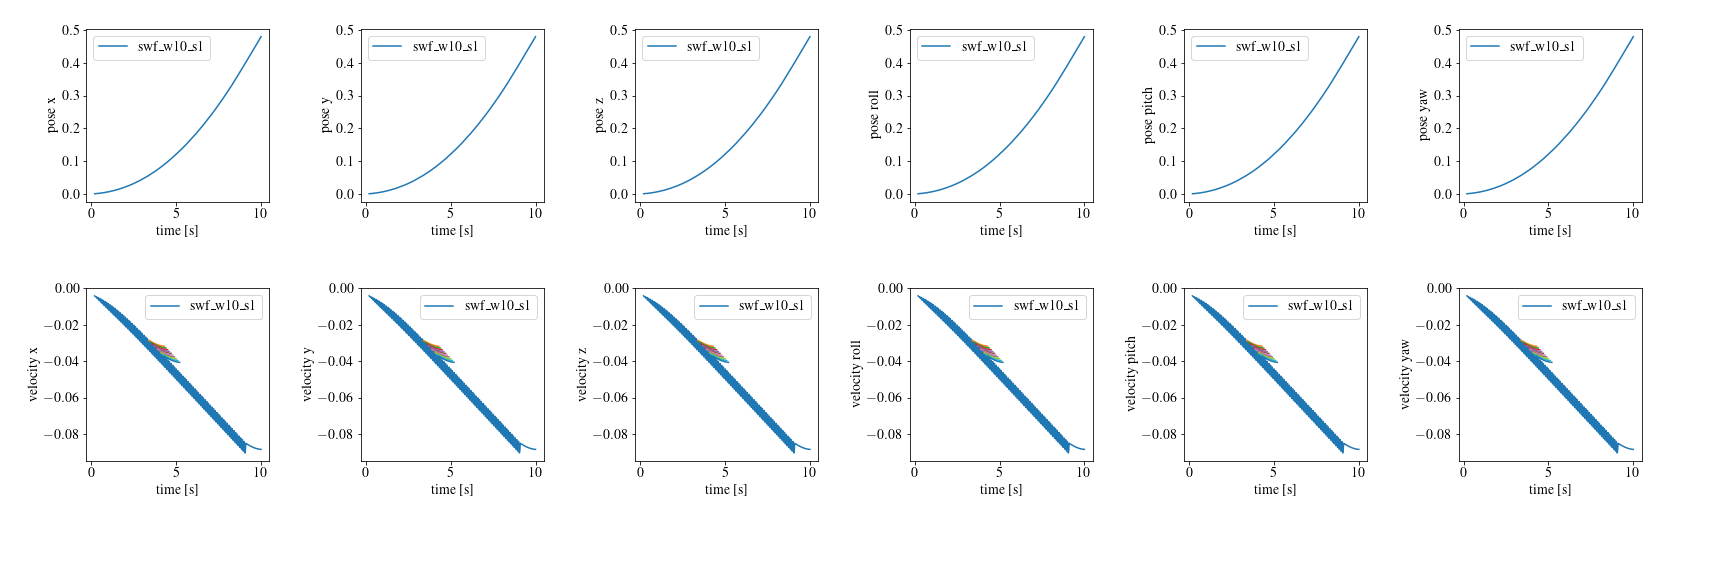

In [6]:
### CONST VEL Prior - Solve using sliding window optimization (with equivalent velocity measurements)
WINDOW_SIZE = 10
STRIDE_SIZE = 1
# qcd = np.array([1., 1., 1., 1., 1., 1.])
qcd = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

T_rm_vars = []
w_mr_inr_vars = []
for t in unique_timestamps:
  T_rm = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
  w_mr_inr = np.zeros((6, 1))
  time = trajectory.Time(secs=t)
  T_rm_vars.append(se3ev.SE3StateVar(T_rm))
  w_mr_inr_vars.append(vspaceev.VSpaceStateVar(w_mr_inr))

#
sliding_window_filter = problem.SlidingWindowFilter()
curr_state_index = -1
marg_state_index = -1

#
curr_state_index += 1
sliding_window_filter.add_variable(T_rm_vars[curr_state_index], w_mr_inr_vars[curr_state_index])

# add cost term
error_func = vspaceev.vspace_error(w_mr_inr_vars[curr_state_index], w_mr_inr_meas_list[curr_state_index])
loss_func = problem.L2LossFunc()
noise_model = problem.StaticNoiseModel(w_mr_inr_meas_cov_list[curr_state_index], "covariance")
cost_term = problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
sliding_window_filter.add_cost_term(cost_term)

# intermediate state values
timestamp_interms = []
T_rm_interms = []
w_mr_inr_interms = []

while curr_state_index + 1 < len(unique_timestamps):
  print(f"curr_state_index: {curr_state_index}", end="\r")

  #
  added_state_index = curr_state_index

  #
  for i in range(STRIDE_SIZE):
    if curr_state_index + 1 >= len(unique_timestamps):
      break
    curr_state_index += 1
    sliding_window_filter.add_variable(T_rm_vars[curr_state_index], w_mr_inr_vars[curr_state_index])

  #
  traj = trajectory.const_vel.Interface(qcd=qcd)

  for i in range(added_state_index, curr_state_index+1):
    knot_time = trajectory.Time(secs=unique_timestamps[i])
    traj.add_knot(time=knot_time, T_k0=T_rm_vars[i], w_0k_ink=w_mr_inr_vars[i])

  # add prior
  if added_state_index == 0:
    time_prior = trajectory.Time(secs=unique_timestamps[0])
    T_rm_prior = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
    w_mr_inr_prior = np.zeros((6, 1))
    traj.add_pose_prior(time_prior, T_rm_prior, np.eye(6))
    traj.add_velocity_prior(time_prior, w_mr_inr_prior, np.eye(6))

  sliding_window_filter.add_cost_term(*traj.get_prior_cost_terms())

  # add cost term
  for i in range(added_state_index+1, curr_state_index+1):
    error_func = vspaceev.vspace_error(w_mr_inr_vars[i], w_mr_inr_meas_list[i])
    loss_func = problem.L2LossFunc()
    noise_model = problem.StaticNoiseModel(w_mr_inr_meas_cov_list[i], "covariance")
    cost_term = problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    sliding_window_filter.add_cost_term(cost_term)

  # marginalize variable
  marg_state_vars = []
  while curr_state_index - marg_state_index > WINDOW_SIZE:
    marg_state_index += 1
    marg_state_vars.append(T_rm_vars[marg_state_index])
    marg_state_vars.append(w_mr_inr_vars[marg_state_index])
  sliding_window_filter.marginalize_variable(*marg_state_vars)

  # Make solver and solve
  optimizer = solver.GaussNewtonSolver(sliding_window_filter, verbose=False)
  optimizer.optimize()

  # append
  timestamp_interm = []
  T_rm_interm = []
  w_mr_inr_interm = []
  for index in range(marg_state_index+1, curr_state_index+1):
    timestamp_interm.append(unique_timestamps[index])
    T_rm_interm.append(T_rm_vars[index].evaluate().matrix())
    w_mr_inr_interm.append(np.copy(w_mr_inr_vars[index].evaluate()))
  timestamp_interms.append(timestamp_interm)
  T_rm_interms.append(T_rm_interm)
  w_mr_inr_interms.append(w_mr_inr_interm)  

## Setup trajectory for plotting
traj = trajectory.const_vel.Interface(qcd=qcd)
for i in range(len(unique_timestamps)):
  knot_time = trajectory.Time(secs=unique_timestamps[i])
  traj.add_knot(time=knot_time, T_k0=T_rm_vars[i], w_0k_ink=w_mr_inr_vars[i])

## plot
timestamps_plot = np.arange(unique_timestamps[0], unique_timestamps[-1], 0.005)
T_mr_plot = []
w_mr_inr_plot = []
for i in timestamps_plot:
  time = trajectory.Time(secs=i)
  T_mr_plot.append(se3ev.inv(traj.get_pose_interpolator(time)).evaluate())
  w_mr_inr_plot.append(traj.get_velocity_interpolator(time).evaluate())

timestamps_plot_swf = timestamps_plot
T_mr_plot_swf = T_mr_plot
w_mr_inr_plot_swf = w_mr_inr_plot

fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.5, hspace=0.5)
add_plot_pose(ax[0], timestamps_plot_swf, T_mr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")
add_plot_velocity(ax[1], timestamps_plot_swf, w_mr_inr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")
add_legend(ax[0], 'pose')
add_legend(ax[1], 'velocity')

for i in range(40, 50):
  traj = trajectory.const_vel.Interface(qcd=qcd)
  for j in range(len(timestamp_interms[i])):
    knot_time = trajectory.Time(secs=timestamp_interms[i][j])
    T_rm = se3ev.SE3StateVar(Transformation(T_ba=T_rm_interms[i][j]))
    w_mr_inr = vspaceev.VSpaceStateVar(w_mr_inr_interms[i][j])
    traj.add_knot(time=knot_time, T_k0=T_rm, w_0k_ink=w_mr_inr)
  #
  timestamp_interm_plot = np.arange(timestamp_interms[i][0], timestamp_interms[i][-1], 0.005)
  T_mr_interm_plot = [se3ev.inv(traj.get_pose_interpolator(trajectory.Time(time))).evaluate() for time in timestamp_interm_plot]
  w_mr_inr_interm_plot = [traj.get_velocity_interpolator(trajectory.Time(time)).evaluate() for time in timestamp_interm_plot]
  add_plot_velocity(ax[1], timestamp_interm_plot, w_mr_inr_interm_plot)

plt.show()

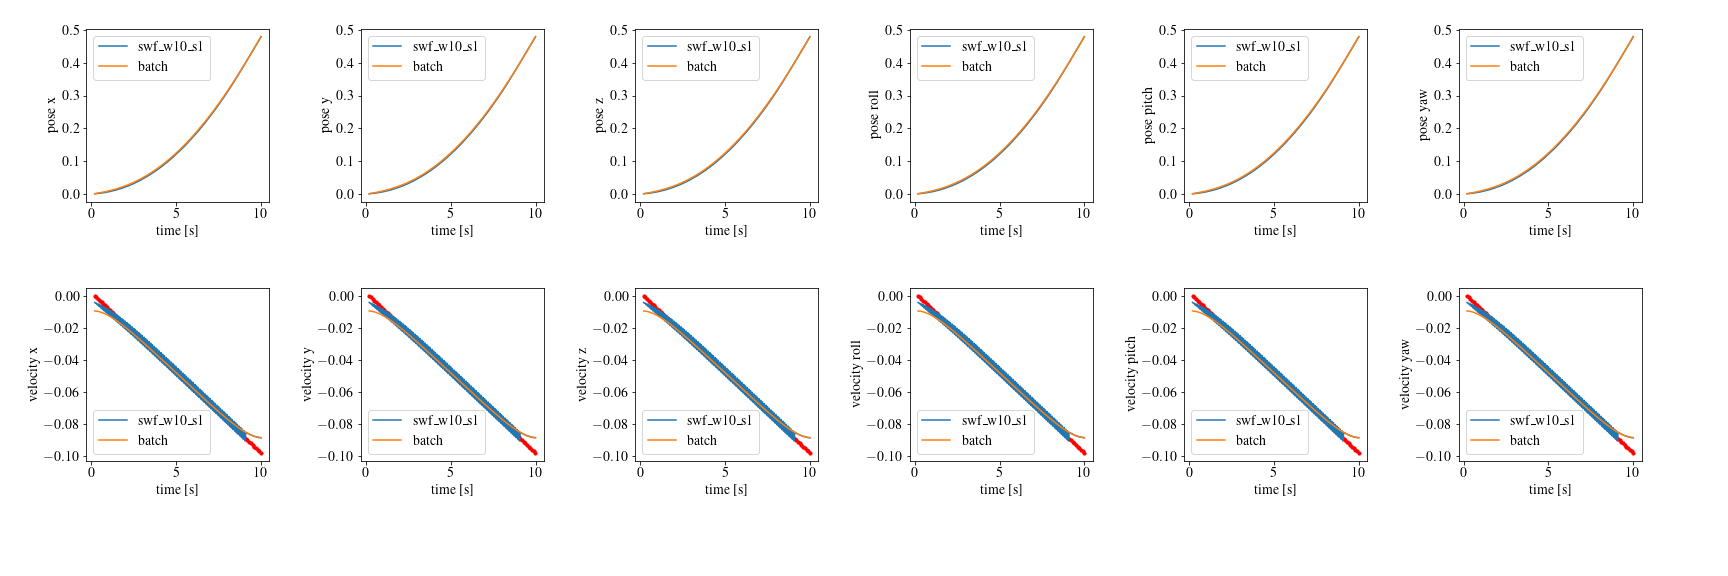

In [17]:
def add_plot_vel_meas(ax, timestamp, w_mr_inr, label=None, color=None, size=None):
    w_mr_inr = np.array(w_mr_inr).squeeze()
    ax[0].scatter(timestamp, w_mr_inr[:, 0], label=label, color=color, s=size)
    ax[1].scatter(timestamp, w_mr_inr[:, 1], label=label, color=color, s=size)
    ax[2].scatter(timestamp, w_mr_inr[:, 2], label=label, color=color, s=size)
    ax[3].scatter(timestamp, w_mr_inr[:, 3+0], label=label, color=color, s=size)
    ax[4].scatter(timestamp, w_mr_inr[:, 3+1], label=label, color=color, s=size)
    ax[5].scatter(timestamp, w_mr_inr[:, 3+2], label=label, color=color, s=size)


fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.5, hspace=0.5)

add_plot_pose(ax[0], timestamps_plot_swf, T_mr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")
add_plot_velocity(ax[1], timestamps_plot_swf, w_mr_inr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")

add_plot_pose(ax[0], timestamps_plot_batch, T_mr_plot_batch, label="batch")
add_plot_velocity(ax[1], timestamps_plot_batch, w_mr_inr_plot_batch, label="batch")

add_plot_vel_meas(ax[1], unique_timestamps, w_mr_inr_meas_list, label=None, color="red", size=10)

add_legend(ax[0], 'pose')
add_legend(ax[1], 'velocity')


# for i in range(40, 50):
#   traj = trajectory.const_vel.Interface(qcd=qcd)
#   for j in range(len(timestamp_interms[i])):
#     knot_time = trajectory.Time(secs=timestamp_interms[i][j])
#     T_rm = se3ev.SE3StateVar(Transformation(T_ba=T_rm_interms[i][j]))
#     w_mr_inr = vspaceev.VSpaceStateVar(w_mr_inr_interms[i][j])
#     traj.add_knot(time=knot_time, T_k0=T_rm, w_0k_ink=w_mr_inr)
#   #
#   timestamp_interm_plot = np.arange(timestamp_interms[i][0], timestamp_interms[i][-1], 0.005)
#   T_mr_interm_plot = [se3ev.inv(traj.get_pose_interpolator(trajectory.Time(time))).evaluate() for time in timestamp_interm_plot]
#   w_mr_inr_interm_plot = [traj.get_velocity_interpolator(trajectory.Time(time)).evaluate() for time in timestamp_interm_plot]
#   add_plot_velocity(ax[1], timestamp_interm_plot, w_mr_inr_interm_plot)

plt.show()

In [ ]:
### CONST ACC Prior - Solve using batch optimization (with equivalent velocity measurements)

## Setup trajectory
qcd = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]) * 0.01
traj = trajectory.const_acc.Interface(qcd=qcd)

T_rm_vars = []
w_mr_inr_vars = []
dw_mr_inr_vars = []
for t in unique_timestamps:
  T_rm = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
  w_mr_inr = np.zeros((6, 1))
  dw_mr_inr = np.zeros((6, 1))
  time = trajectory.Time(secs=t)
  T_rm_vars.append(se3ev.SE3StateVar(T_rm))
  w_mr_inr_vars.append(vspaceev.VSpaceStateVar(w_mr_inr))
  dw_mr_inr_vars.append(vspaceev.VSpaceStateVar(dw_mr_inr))
  traj.add_knot(time=time, T_k0=T_rm_vars[-1], w_0k_ink=w_mr_inr_vars[-1], dw_0k_ink=dw_mr_inr_vars[-1])

## prior on initial time
time_prior = trajectory.Time(secs=unique_timestamps[0])
T_rm_prior = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
w_mr_inr_prior = np.zeros((6, 1))
dw_mr_inr_prior = np.zeros((6, 1))
traj.add_pose_prior(time_prior, T_rm_prior, np.eye(6))
traj.add_velocity_prior(time_prior, w_mr_inr_prior, np.eye(6))
traj.add_acceleration_prior(time_prior, dw_mr_inr_prior, np.eye(6))

## Setup cost terms
cost_terms = []
for i in range(len(unique_timestamps)):
  time = trajectory.Time(secs=unique_timestamps[i])
  w_mr_inr_meas = w_mr_inr_meas_list[i]
  w_mr_inr_meas_cov = w_mr_inr_meas_cov_list[i]

  w_mr_inr_eval = traj.get_velocity_interpolator(time)
  error_func = vspaceev.vspace_error(w_mr_inr_eval, w_mr_inr_meas)
  loss_func = problem.L2LossFunc()
  noise_model = problem.StaticNoiseModel(w_mr_inr_meas_cov, "covariance")
  cost_terms.append(problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func))

## Make optimization problem
opt_prob = problem.OptimizationProblem()
opt_prob.add_state_var(*T_rm_vars, *w_mr_inr_vars, *dw_mr_inr_vars)
opt_prob.add_cost_term(*cost_terms, *traj.get_prior_cost_terms())

## Make solver and solve
optimizer = solver.GaussNewtonSolver(opt_prob, verbose=True)
optimizer.optimize()

## plot
timestamps_plot = np.arange(unique_timestamps[0], unique_timestamps[-1], 0.005)
T_mr_plot = []
w_mr_inr_plot = []
for i in timestamps_plot:
  time = trajectory.Time(secs=i)
  T_mr_plot.append(se3ev.inv(traj.get_pose_interpolator(time)).evaluate())
  w_mr_inr_plot.append(traj.get_velocity_interpolator(time).evaluate())

timestamps_plot_batch = timestamps_plot
T_mr_plot_batch = T_mr_plot
w_mr_inr_plot_batch = w_mr_inr_plot

fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.5, hspace=0.5)
add_plot_pose(ax[0], timestamps_plot_batch, T_mr_plot_batch, label="batch")
add_plot_velocity(ax[1], timestamps_plot_batch, w_mr_inr_plot_batch, label="batch")
add_legend(ax[0], 'pose')
add_legend(ax[1], 'velocity')
plt.show()

In [ ]:
### CONST ACC Prior - Solve using sliding window optimization (with equivalent velocity measurements)
WINDOW_SIZE = 10
STRIDE_SIZE = 1
qcd = np.array([1., 1., 1., 1., 1., 1.]) * 0.01

T_rm_vars = []
w_mr_inr_vars = []
dw_mr_inr_vars = []
for t in unique_timestamps:
  T_rm = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
  w_mr_inr = np.zeros((6, 1))
  dw_mr_inr = np.zeros((6, 1))
  time = trajectory.Time(secs=t)
  T_rm_vars.append(se3ev.SE3StateVar(T_rm))
  w_mr_inr_vars.append(vspaceev.VSpaceStateVar(w_mr_inr))
  dw_mr_inr_vars.append(vspaceev.VSpaceStateVar(dw_mr_inr))

#
sliding_window_filter = filter.SlidingWindowFilter()
curr_state_index = -1
marg_state_index = -1

#
curr_state_index += 1
sliding_window_filter.add_variable(T_rm_vars[curr_state_index], w_mr_inr_vars[curr_state_index], dw_mr_inr_vars[curr_state_index])

# add cost term
error_func = vspaceev.vspace_error(w_mr_inr_vars[curr_state_index], w_mr_inr_meas_list[curr_state_index])
loss_func = problem.L2LossFunc()
noise_model = problem.StaticNoiseModel(w_mr_inr_meas_cov_list[curr_state_index], "covariance")
cost_term = problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
sliding_window_filter.add_cost_term(cost_term)

while curr_state_index + 1 < len(unique_timestamps):
  print(f"curr_state_index: {curr_state_index}", end="\r")

  #
  added_state_index = curr_state_index

  #
  for i in range(STRIDE_SIZE):
    if curr_state_index + 1 >= len(unique_timestamps):
      break
    curr_state_index += 1
    sliding_window_filter.add_variable(T_rm_vars[curr_state_index], w_mr_inr_vars[curr_state_index], dw_mr_inr_vars[curr_state_index])

  #
  traj = trajectory.const_acc.Interface(qcd=qcd)

  for i in range(added_state_index, curr_state_index+1):
    knot_time = trajectory.Time(secs=unique_timestamps[i])
    traj.add_knot(time=knot_time, T_k0=T_rm_vars[i], w_0k_ink=w_mr_inr_vars[i], dw_0k_ink=dw_mr_inr_vars[i])

  # add prior
  if added_state_index == 0:
    time_prior = trajectory.Time(secs=unique_timestamps[0])
    T_rm_prior = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
    w_mr_inr_prior = np.zeros((6, 1))
    dw_mr_inr_prior = np.zeros((6, 1))
    traj.add_pose_prior(time_prior, T_rm_prior, np.eye(6))
    traj.add_velocity_prior(time_prior, w_mr_inr_prior, np.eye(6))
    traj.add_acceleration_prior(time_prior, dw_mr_inr_prior, np.eye(6))

  sliding_window_filter.add_cost_term(*traj.get_prior_cost_terms())

  # add cost term
  for i in range(added_state_index+1, curr_state_index+1):
    error_func = vspaceev.vspace_error(w_mr_inr_vars[i], w_mr_inr_meas_list[i])
    loss_func = problem.L2LossFunc()
    noise_model = problem.StaticNoiseModel(w_mr_inr_meas_cov_list[i], "covariance")
    cost_term = problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    sliding_window_filter.add_cost_term(cost_term)

  # marginalize variable
  marg_state_vars = []
  while curr_state_index - marg_state_index > WINDOW_SIZE:
    marg_state_index += 1
    marg_state_vars.append(T_rm_vars[marg_state_index])
    marg_state_vars.append(w_mr_inr_vars[marg_state_index])
    marg_state_vars.append(dw_mr_inr_vars[marg_state_index])
  sliding_window_filter.marginalize_variable(*marg_state_vars)

  # Make solver and solve
  optimizer = solver.GaussNewtonSolver(sliding_window_filter, verbose=False, max_iterations=20)  # TODO: run until convergence
  optimizer.optimize()

## Setup trajectory for plotting
traj = trajectory.const_acc.Interface(qcd=qcd)
for i in range(len(unique_timestamps)):
  knot_time = trajectory.Time(secs=unique_timestamps[i])
  traj.add_knot(time=knot_time, T_k0=T_rm_vars[i], w_0k_ink=w_mr_inr_vars[i], dw_0k_ink=dw_mr_inr_vars[i])

## plot
timestamps_plot = np.arange(unique_timestamps[0], unique_timestamps[-1], 0.005)
T_mr_plot = []
w_mr_inr_plot = []
for i in timestamps_plot:
  time = trajectory.Time(secs=i)
  T_mr_plot.append(se3ev.inv(traj.get_pose_interpolator(time)).evaluate())
  w_mr_inr_plot.append(traj.get_velocity_interpolator(time).evaluate())

timestamps_plot_swf = timestamps_plot
T_mr_plot_swf = T_mr_plot
w_mr_inr_plot_swf = w_mr_inr_plot

fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.5, hspace=0.5)
add_plot_pose(ax[0], timestamps_plot_swf, T_mr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")
add_plot_velocity(ax[1], timestamps_plot_swf, w_mr_inr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")
add_legend(ax[0], 'pose')
add_legend(ax[1], 'velocity')
plt.show()

In [ ]:
def add_plot_vel_meas(ax, timestamp, w_mr_inr, label=None, color=None, size=None):
    w_mr_inr = np.array(w_mr_inr).squeeze()
    ax[0].scatter(timestamp, w_mr_inr[:, 0], label=label, color=color, s=size)
    ax[1].scatter(timestamp, w_mr_inr[:, 1], label=label, color=color, s=size)
    ax[2].scatter(timestamp, w_mr_inr[:, 2], label=label, color=color, s=size)
    ax[3].scatter(timestamp, w_mr_inr[:, 3+0], label=label, color=color, s=size)
    ax[4].scatter(timestamp, w_mr_inr[:, 3+1], label=label, color=color, s=size)
    ax[5].scatter(timestamp, w_mr_inr[:, 3+2], label=label, color=color, s=size)


fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.5, hspace=0.5)
add_plot_pose(ax[0], timestamps_plot_batch, T_mr_plot_batch, label="batch")
add_plot_velocity(ax[1], timestamps_plot_batch, w_mr_inr_plot_batch, label="batch")

add_plot_pose(ax[0], timestamps_plot_swf, T_mr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")
add_plot_velocity(ax[1], timestamps_plot_swf, w_mr_inr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")

add_plot_vel_meas(ax[1], unique_timestamps, w_mr_inr_meas_list, label=None, color="red", size=10)

add_legend(ax[0], 'pose')
add_legend(ax[1], 'velocity')
plt.show()

In [ ]:
### Singer Prior - Solve using batch optimization (with equivalent velocity measurements)

## Setup trajectory
qcd = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]) * 0.01
ad = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
traj = trajectory.singer.Interface(qcd=qcd, ad=ad)

T_rm_vars = []
w_mr_inr_vars = []
dw_mr_inr_vars = []
for t in unique_timestamps:
  T_rm = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
  w_mr_inr = np.zeros((6, 1))
  dw_mr_inr = np.zeros((6, 1))
  time = trajectory.Time(secs=t)
  T_rm_vars.append(se3ev.SE3StateVar(T_rm))
  w_mr_inr_vars.append(vspaceev.VSpaceStateVar(w_mr_inr))
  dw_mr_inr_vars.append(vspaceev.VSpaceStateVar(dw_mr_inr))
  traj.add_knot(time=time, T_k0=T_rm_vars[-1], w_0k_ink=w_mr_inr_vars[-1], dw_0k_ink=dw_mr_inr_vars[-1])

## prior on initial time
time_prior = trajectory.Time(secs=unique_timestamps[0])
T_rm_prior = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
w_mr_inr_prior = np.zeros((6, 1))
dw_mr_inr_prior = -np.ones((6, 1))
traj.add_pose_prior(time_prior, T_rm_prior, np.eye(6))
traj.add_velocity_prior(time_prior, w_mr_inr_prior, np.eye(6))
traj.add_acceleration_prior(time_prior, dw_mr_inr_prior, np.eye(6))

## Setup cost terms
cost_terms = []
# for i in range(len(unique_timestamps)):
#   time = trajectory.Time(secs=unique_timestamps[i])
#   w_mr_inr_meas = w_mr_inr_meas_list[i]
#   w_mr_inr_meas_cov = w_mr_inr_meas_cov_list[i]

#   w_mr_inr_eval = traj.get_velocity_interpolator(time)
#   error_func = vspaceev.vspace_error(w_mr_inr_eval, w_mr_inr_meas)
#   loss_func = problem.L2LossFunc()
#   noise_model = problem.StaticNoiseModel(w_mr_inr_meas_cov, "covariance")
#   cost_terms.append(problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func))

## Make optimization problem
opt_prob = problem.OptimizationProblem()
opt_prob.add_state_var(*T_rm_vars, *w_mr_inr_vars, *dw_mr_inr_vars)
opt_prob.add_cost_term(*cost_terms, *traj.get_prior_cost_terms())

## Make solver and solve
optimizer = solver.GaussNewtonSolver(opt_prob, verbose=True)
optimizer.optimize()

## plot
timestamps_plot = np.arange(unique_timestamps[0], unique_timestamps[-1], 0.005)
T_mr_plot = []
w_mr_inr_plot = []
for i in timestamps_plot:
  time = trajectory.Time(secs=i)
  T_mr_plot.append(se3ev.inv(traj.get_pose_interpolator(time)).evaluate())
  w_mr_inr_plot.append(traj.get_velocity_interpolator(time).evaluate())

timestamps_plot_batch = timestamps_plot
T_mr_plot_batch = T_mr_plot
w_mr_inr_plot_batch = w_mr_inr_plot

fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.5, hspace=0.5)
add_plot_pose(ax[0], timestamps_plot_batch, T_mr_plot_batch, label="batch")
add_plot_velocity(ax[1], timestamps_plot_batch, w_mr_inr_plot_batch, label="batch")
add_legend(ax[0], 'pose')
add_legend(ax[1], 'velocity')
plt.show()

In [ ]:
### Singer Prior - Solve using sliding window optimization (with equivalent velocity measurements)
WINDOW_SIZE = 10
STRIDE_SIZE = 1
qcd = np.array([1., 1., 1., 1., 1., 1.]) * 0.01
ad = np.array([1., 1., 1., 1., 1., 1.])

T_rm_vars = []
w_mr_inr_vars = []
dw_mr_inr_vars = []
for t in unique_timestamps:
  T_rm = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
  w_mr_inr = np.zeros((6, 1))
  dw_mr_inr = np.zeros((6, 1))
  time = trajectory.Time(secs=t)
  T_rm_vars.append(se3ev.SE3StateVar(T_rm))
  w_mr_inr_vars.append(vspaceev.VSpaceStateVar(w_mr_inr))
  dw_mr_inr_vars.append(vspaceev.VSpaceStateVar(dw_mr_inr))

#
sliding_window_filter = filter.SlidingWindowFilter()
curr_state_index = -1
marg_state_index = -1

#
curr_state_index += 1
sliding_window_filter.add_variable(T_rm_vars[curr_state_index], w_mr_inr_vars[curr_state_index], dw_mr_inr_vars[curr_state_index])

# add cost term
error_func = vspaceev.vspace_error(w_mr_inr_vars[curr_state_index], w_mr_inr_meas_list[curr_state_index])
loss_func = problem.L2LossFunc()
noise_model = problem.StaticNoiseModel(w_mr_inr_meas_cov_list[curr_state_index], "covariance")
cost_term = problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
sliding_window_filter.add_cost_term(cost_term)

while curr_state_index + 1 < len(unique_timestamps):
  print(f"curr_state_index: {curr_state_index}", end="\r")

  #
  added_state_index = curr_state_index

  #
  for i in range(STRIDE_SIZE):
    if curr_state_index + 1 >= len(unique_timestamps):
      break
    curr_state_index += 1
    sliding_window_filter.add_variable(T_rm_vars[curr_state_index], w_mr_inr_vars[curr_state_index], dw_mr_inr_vars[curr_state_index])

  #
  traj = trajectory.singer.Interface(qcd=qcd, ad=ad)

  for i in range(added_state_index, curr_state_index+1):
    knot_time = trajectory.Time(secs=unique_timestamps[i])
    traj.add_knot(time=knot_time, T_k0=T_rm_vars[i], w_0k_ink=w_mr_inr_vars[i], dw_0k_ink=dw_mr_inr_vars[i])

  # add prior
  if added_state_index == 0:
    time_prior = trajectory.Time(secs=unique_timestamps[0])
    T_rm_prior = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
    w_mr_inr_prior = np.zeros((6, 1))
    dw_mr_inr_prior = np.zeros((6, 1))
    traj.add_pose_prior(time_prior, T_rm_prior, np.eye(6))
    traj.add_velocity_prior(time_prior, w_mr_inr_prior, np.eye(6))
    traj.add_acceleration_prior(time_prior, dw_mr_inr_prior, np.eye(6))

  sliding_window_filter.add_cost_term(*traj.get_prior_cost_terms())

  # add cost term
  for i in range(added_state_index+1, curr_state_index+1):
    error_func = vspaceev.vspace_error(w_mr_inr_vars[i], w_mr_inr_meas_list[i])
    loss_func = problem.L2LossFunc()
    noise_model = problem.StaticNoiseModel(w_mr_inr_meas_cov_list[i], "covariance")
    cost_term = problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    sliding_window_filter.add_cost_term(cost_term)

  # marginalize variable
  marg_state_vars = []
  while curr_state_index - marg_state_index > WINDOW_SIZE:
    marg_state_index += 1
    marg_state_vars.append(T_rm_vars[marg_state_index])
    marg_state_vars.append(w_mr_inr_vars[marg_state_index])
    marg_state_vars.append(dw_mr_inr_vars[marg_state_index])
  sliding_window_filter.marginalize_variable(*marg_state_vars)

  # Make solver and solve
  optimizer = solver.GaussNewtonSolver(sliding_window_filter, verbose=False, max_iterations=20)  # TODO: run until convergence
  optimizer.optimize()

## Setup trajectory for plotting
traj = trajectory.singer.Interface(qcd=qcd, ad=ad)
for i in range(len(unique_timestamps)):
  knot_time = trajectory.Time(secs=unique_timestamps[i])
  traj.add_knot(time=knot_time, T_k0=T_rm_vars[i], w_0k_ink=w_mr_inr_vars[i], dw_0k_ink=dw_mr_inr_vars[i])

## plot
timestamps_plot = np.arange(unique_timestamps[0], unique_timestamps[-1], 0.005)
T_mr_plot = []
w_mr_inr_plot = []
for i in timestamps_plot:
  time = trajectory.Time(secs=i)
  T_mr_plot.append(se3ev.inv(traj.get_pose_interpolator(time)).evaluate())
  w_mr_inr_plot.append(traj.get_velocity_interpolator(time).evaluate())

timestamps_plot_swf = timestamps_plot
T_mr_plot_swf = T_mr_plot
w_mr_inr_plot_swf = w_mr_inr_plot

fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.5, hspace=0.5)
add_plot_pose(ax[0], timestamps_plot_swf, T_mr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")
add_plot_velocity(ax[1], timestamps_plot_swf, w_mr_inr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")
add_legend(ax[0], 'pose')
add_legend(ax[1], 'velocity')
plt.show()

In [ ]:
def add_plot_vel_meas(ax, timestamp, w_mr_inr, label=None, color=None, size=None):
    w_mr_inr = np.array(w_mr_inr).squeeze()
    ax[0].scatter(timestamp, w_mr_inr[:, 0], label=label, color=color, s=size)
    ax[1].scatter(timestamp, w_mr_inr[:, 1], label=label, color=color, s=size)
    ax[2].scatter(timestamp, w_mr_inr[:, 2], label=label, color=color, s=size)
    ax[3].scatter(timestamp, w_mr_inr[:, 3+0], label=label, color=color, s=size)
    ax[4].scatter(timestamp, w_mr_inr[:, 3+1], label=label, color=color, s=size)
    ax[5].scatter(timestamp, w_mr_inr[:, 3+2], label=label, color=color, s=size)


fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.5, hspace=0.5)
add_plot_pose(ax[0], timestamps_plot_batch, T_mr_plot_batch, label="batch")
add_plot_velocity(ax[1], timestamps_plot_batch, w_mr_inr_plot_batch, label="batch")

add_plot_pose(ax[0], timestamps_plot_swf, T_mr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")
add_plot_velocity(ax[1], timestamps_plot_swf, w_mr_inr_plot_swf, label=f"swf_w{WINDOW_SIZE}_s{STRIDE_SIZE}")

add_plot_vel_meas(ax[1], unique_timestamps, w_mr_inr_meas_list, label=None, color="red", size=10)

add_legend(ax[0], 'pose')
add_legend(ax[1], 'velocity')
plt.show()